<a href="https://colab.research.google.com/github/ronmaccms/macadThesis24/blob/main/Burgers1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

In [80]:
class NN(nn.Module):
  def __init__(self):
    super(NN, self).__init__()
    self.net = torch.nn.Sequential(
        nn.Linear(2,20),
        nn.Tanh(),
        nn.Linear(20,30),
        nn.Tanh(),
        nn.Linear(30,30),
        nn.Tanh(),
        nn.Linear(30,20),
        nn.Tanh(),
        nn.Linear(20,20),
        nn.Tanh(),
        nn.Linear(20,1)
    )
  def forward(self, x):
    out = self.net(x)
    return out

In [81]:
# class Net:
#   def __init__(self):
#     device = torch.device("cude") if torch.cuda.is_available() else torch.device("cpu")

#     self.h = 0.1
#     self.k = 0.1
#     x = torch.arange(-1,1+self.h, self.h)
#     t = torch.arange(-1,1+self.k, self.k)

#     self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T

In [82]:
# x_test = torch.arange(-1,1+0.1, 0.1)
# print(x_test)
# t_test = torch.arange(0,1+0.1, 0.1)
# print(t_test)

# X = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T
# print(X)

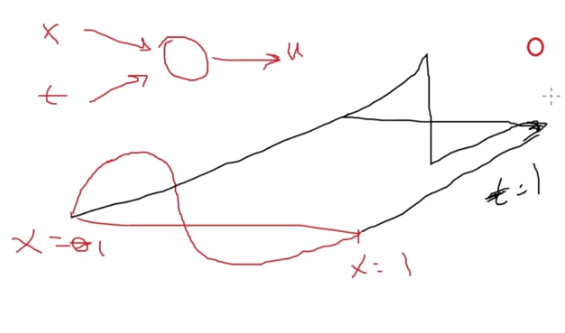

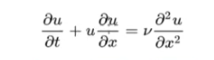

In [83]:
'''x_test = torch.arange(-1,1+0.1, 0.1)
# print(x_test)
t_test = torch.arange(0,1+0.1, 0.1)
# print(t_test)

X = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T
# print(X)

bc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T
# print(bc1_test)
# print(torch.meshgrid(x_test,t_test))

y_train_test = torch.tensor([1,2,3,4])
print(y_train_test)
y_train_test = y_train_test.unsqueeze(1)
print(y_train_test)'''

'x_test = torch.arange(-1,1+0.1, 0.1)\n# print(x_test)\nt_test = torch.arange(0,1+0.1, 0.1)\n# print(t_test)\n\nX = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T\n# print(X)\n\nbc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T\n# print(bc1_test)\n# print(torch.meshgrid(x_test,t_test))\n\ny_train_test = torch.tensor([1,2,3,4])\nprint(y_train_test)\ny_train_test = y_train_test.unsqueeze(1)\nprint(y_train_test)'

In [84]:
class Net:
    def __init__(self):
      device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

      self.model = NN().to(device)

      # comp. domain
      self.h = 0.1
      self.k = 0.1
      x = torch.arange(-1,1+self.h, self.h)
      t = torch.arange(0,1+self.k, self.k)

      self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T

      # train data / initial conditions and boundaries
      bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T # boundary condition 1
      bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
      ic = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
      self.X_train = torch.cat([bc1, bc2, ic])

      y_bc1 = torch.zeros(len(bc1))
      y_bc2 = torch.zeros(len(bc2))
      y_ic = -torch.sin(math.pi * ic[:,0])
      self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
      self.y_train = self.y_train.unsqueeze(1)

      self.X = self.X.to(device)
      self.y_train = self.y_train.to(device)
      self.X_train = self.X_train.to(device)
      self.X.requires_grad = True

      # Optimizer settings
      self.adam =  torch.optim.Adam(self.model.parameters())
      # limited memory broyden-fletcher-goldfarb-shanno (L-BFGS)
      # we start by optimising the whole network and we twick the weights with a more accurate number
      self.optimizer = torch.optim.LBFGS(
          self.model.parameters(),
          lr = 1.0,
          max_iter= 50000,
          max_eval = 50000,
          history_size = 50,
          tolerance_grad = 1e-7,
          tolerance_change = 1.0* np.finfo(float).eps,
          line_search_fn ="strong_wolfe"
      )

      self.criterion = torch.nn.MSELoss()
      self.iter = 1

    # now we calculate the loss - very important
    def loss_func(self):
      self.adam.zero_grad()
      self.optimizer.zero_grad()

      y_pred = self.model(self.X_train)
      loss_data = self.criterion(y_pred, self.y_train)

      u = self.model(self.X)

      du_dX = torch.autograd.grad(
          u,
          self.X,
          grad_outputs = torch.ones_like(u),
          create_graph = True,
          retain_graph = True
      )[0]

      # print(du_dX)
      # print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
      # print(du_dX[0])

      du_dt = du_dX[:,1]
      du_dx = du_dX[:,0]

      du_dXX = torch.autograd.grad(
          du_dX,
          self.X,
          grad_outputs = torch.ones_like(du_dX),
          create_graph = True,
          retain_graph = True
      )[0]

      du_dxx = du_dXX[:,0]

      loss_pde = self.criterion(du_dt + u.squeeze()*du_dx , (0.01/math.pi) * du_dxx)

      loss = loss_pde + loss_data
      loss.backward()

      if self.iter % 100 == 0:
          print(self.iter, loss.item())
      self.iter = self.iter+1

      return loss

    # now we train the model
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [85]:
# training
net = Net()
net.train()

100 0.18831312656402588
200 0.09393493831157684
300 0.07827679812908173
400 0.06661049276590347
500 0.04451657086610794
600 0.03086206316947937
700 0.021871723234653473
800 0.027423419058322906
900 0.020160136744379997
1000 0.020388247445225716
1100 0.00844495464116335
1200 0.006482836324721575
1300 0.004479981027543545
1400 0.0031729834154248238
1500 0.0025488249957561493
1600 0.002125635975971818
1700 0.0017839085776358843
1800 0.0015591104747727513
1900 0.0013707366306334734
2000 0.0012009579222649336
2100 0.0010197953088209033
2200 0.0008720762562006712
2300 0.0007223979337140918
2400 0.0005961292190477252
2500 0.0005111525533720851
2600 0.000394347938708961
2700 0.0003117314481642097
2800 0.0002869839081540704
2900 0.0002676554722711444
3000 0.00023941056861076504
3100 0.000213670136872679
3200 0.00019805150805041194
3300 0.0001789577363524586
3400 0.00016626276192255318
3500 0.00015755867934785783
3600 0.00014772656140848994
3700 0.00013742968440055847
3800 0.0001268797495868057


In [86]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [87]:
h = 0.01
k = 0.01

x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X = X.to(net.X.device)

In [88]:
X

tensor([[-1.0000,  0.0000],
        [-1.0000,  0.0100],
        [-1.0000,  0.0200],
        ...,
        [ 0.9900,  0.9700],
        [ 0.9900,  0.9800],
        [ 0.9900,  0.9900]], device='cuda:0')

In [90]:
X.shape

torch.Size([20000, 2])

In [94]:
model = net.model
model.eval()
with torch.no_grad():
  y_pred = model(X)
  y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [95]:
y_pred.shape

(200, 100)

In [96]:
y_pred

array([[ 0.00230817,  0.00183468,  0.00145585, ..., -0.00084103,
        -0.00086529, -0.00088818],
       [ 0.03412148,  0.03269479,  0.03141034, ...,  0.00649215,
         0.00641163,  0.00633331],
       [ 0.06573339,  0.06337042,  0.06119612, ...,  0.01385926,
         0.0137219 ,  0.01358804],
       ...,
       [-0.0929886 , -0.09041488, -0.08799668, ..., -0.02522609,
        -0.0250444 , -0.02486615],
       [-0.06161714, -0.05999616, -0.05847754, ..., -0.01732589,
        -0.01720776, -0.01709224],
       [-0.03008081, -0.02942447, -0.02881479, ..., -0.00940444,
        -0.00935034, -0.00929759]], dtype=float32)

In [97]:
sns.set_style("white")
plt.figure(figsize=(5,3), dpi=3000)
sns.heatmap(y_pred, cmap="jet")

<Axes: >

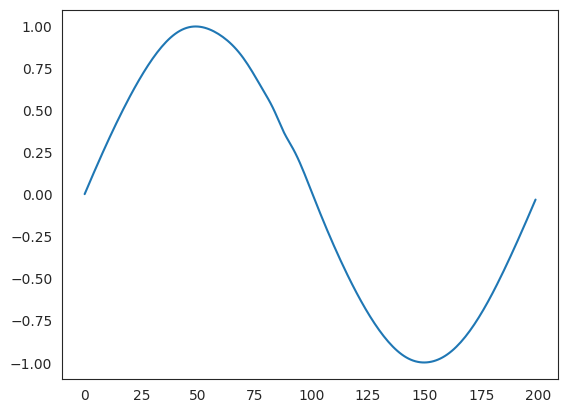

In [99]:
plt.plot(y_pred[:,0])

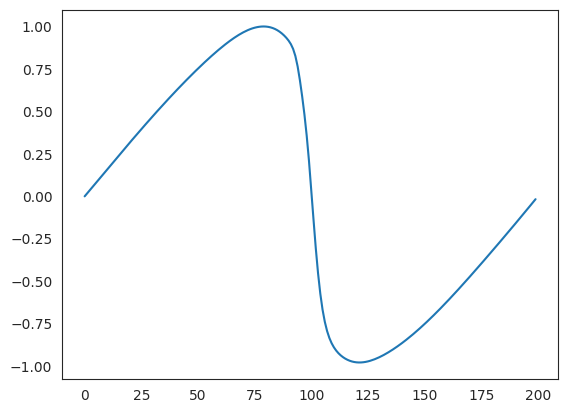

In [104]:
plt.plot(y_pred[:,30])

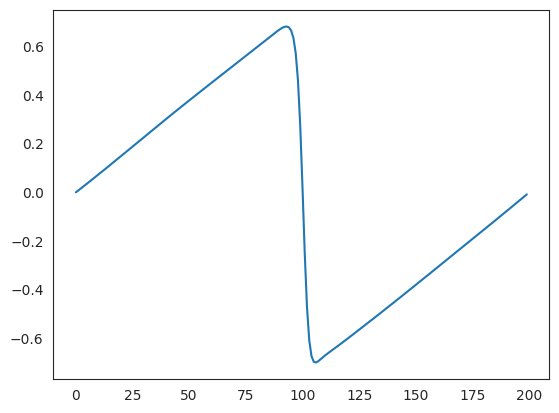

In [105]:
plt.plot(y_pred[:,-1])